# NLP Final Project
#### Submitted by: Sukhmandeep Singh (849742)

**Data Description:** The dataset is collected from two news websites, theonion.com and huffingtonpost.com.
This new dataset has the following advantages over the existing Twitter datasets:


Since news headlines are written by professionals in a formal manner, there are no spelling mistakes and informal usage. This
reduces the sparsity and also increases the chance of finding pre-trained embeddings.

Furthermore, since the sole purpose of TheOnion is to publish sarcastic news, we get high-quality labels with much less noise as compared to Twitter datasets.

Unlike tweets that reply to other tweets, the news headlines obtained are self-contained. This would help us in teasing apart the real sarcastic elements


Content: Each record consists of three attributes:

- is_sarcastic: 1 if the record is sarcastic otherwise 0
- headline: the headline of the news article
- article_link: link to the original news article. Useful in collecting supplementary data


Reference: https://github.com/rishabhmisra/News-Headlines-Dataset-For-Sarcasm-Detection

**Project Objective:** Build a sequential NLP classifier which can use input text parameters to determine the
customer sentiments.

### Importing libraries

In [1]:
import os
import re
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import string
import seaborn as sns
import joblib
import tensorflow as tf
import math
import nltk
import json
import pickle
sns.set(color_codes=True)
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from langdetect import detect
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Flatten, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.initializers import Constant

In [2]:
data = pd.read_json('C:/Users/goods/Downloads/Sarcasm_Headlines_Dataset.json', lines=True)

In [3]:
data

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...
...,...,...,...
28614,1,jews to celebrate rosh hashasha or something,https://www.theonion.com/jews-to-celebrate-ros...
28615,1,internal affairs investigator disappointed con...,https://local.theonion.com/internal-affairs-in...
28616,0,the most beautiful acceptance speech this week...,https://www.huffingtonpost.com/entry/andrew-ah...
28617,1,mars probe destroyed by orbiting spielberg-gat...,https://www.theonion.com/mars-probe-destroyed-...


In [122]:
data.isna().sum()

is_sarcastic    0
headline        0
article_link    0
dtype: int64

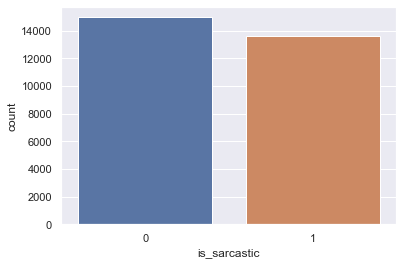

In [123]:
sns.countplot(x = 'is_sarcastic', data=data, );

In [124]:
data.is_sarcastic.value_counts()

0    14985
1    13634
Name: is_sarcastic, dtype: int64

In [125]:
huffing_sarc = data.loc[(data.article_link.str.contains('huffingtonpost.com')) & (data.is_sarcastic==1)].shape[0]
huffing_non = data.loc[(data.article_link.str.contains('huffingtonpost.com')) & (data.is_sarcastic==0)].shape[0]
theo_sarc = data.loc[(data.article_link.str.contains('theonion.com')) & (data.is_sarcastic==1)].shape[0]
theo_non = data.loc[(data.article_link.str.contains('theonion.com')) & (data.is_sarcastic==0)].shape[0]

In [126]:
display(pd.DataFrame([[huffing_sarc,theo_sarc],[huffing_non,theo_non]],
                     columns = ['huffingtonpost.com', 'theonion.com'], index = ['Sarcastic', 'Non-sarcastic']))

,huffingtonpost.com,theonion.com
Sarcastic,0,13634
Non-sarcastic,14985,1


### Dropping irrelevant columns

In [127]:
data.drop('article_link', axis = 1, inplace = True)

In [128]:
data

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...
...,...,...
28614,1,jews to celebrate rosh hashasha or something
28615,1,internal affairs investigator disappointed con...
28616,0,the most beautiful acceptance speech this week...
28617,1,mars probe destroyed by orbiting spielberg-gat...


In [4]:
a=[]
for i in data.headline:
    a.append(len(i))

In [5]:
data_wLen = pd.DataFrame(columns=['is_sarcastic','headline','length'])

In [6]:
data_wLen.is_sarcastic = data.is_sarcastic
data_wLen.headline = data.headline
data_wLen.length = a

In [7]:
data.headline[0]

'thirtysomething scientists unveil doomsday clock of hair loss'

In [132]:
data_wLen

,is_sarcastic,headline,length
0,1,thirtysomething scientists unveil doomsday clo...,61
1,0,dem rep. totally nails why congress is falling...,79
2,0,eat your veggies: 9 deliciously different recipes,49
3,1,inclement weather prevents liar from getting t...,52
4,1,mother comes pretty close to using word 'strea...,61
...,...,...,...
28614,1,jews to celebrate rosh hashasha or something,44
28615,1,internal affairs investigator disappointed con...,87
28616,0,the most beautiful acceptance speech this week...,71
28617,1,mars probe destroyed by orbiting spielberg-gat...,61


In [133]:
print('Maximum Length of Headline:',np.max(data_wLen.length))
print('Minimum Length of Headline:',np.min(data_wLen.length))
print('Average Length of Headline:',np.mean(data_wLen.length))
print('Standard Deviation:',round(np.std(data_wLen.length)))

Maximum Length of Headline: 926
Minimum Length of Headline: 7
Average Length of Headline: 62.30857122890387
Standard Deviation: 21


### Data preprocessing

In [134]:
data['cleaned_headline'] = data.headline.apply(lambda x : x.lower())

In [135]:
data.cleaned_headline[29]

"i'm bi. it took me 21 years to come out of the closet and say it."

In [136]:
data

,is_sarcastic,headline,cleaned_headline
0,1,thirtysomething scientists unveil doomsday clo...,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...,mother comes pretty close to using word 'strea...
...,...,...,...
28614,1,jews to celebrate rosh hashasha or something,jews to celebrate rosh hashasha or something
28615,1,internal affairs investigator disappointed con...,internal affairs investigator disappointed con...
28616,0,the most beautiful acceptance speech this week...,the most beautiful acceptance speech this week...
28617,1,mars probe destroyed by orbiting spielberg-gat...,mars probe destroyed by orbiting spielberg-gat...


#### Cleaning data

In [137]:
cleaned_t = []
for words in data['cleaned_headline']:
    da = re.sub('[^A-Za-z]+',' ',words)
    cleaned_t.append(da)

In [138]:
data['cleaned_headline'] = cleaned_t

In [139]:
data

,is_sarcastic,headline,cleaned_headline
0,1,thirtysomething scientists unveil doomsday clo...,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...,dem rep totally nails why congress is falling ...
2,0,eat your veggies: 9 deliciously different recipes,eat your veggies deliciously different recipes
3,1,inclement weather prevents liar from getting t...,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...,mother comes pretty close to using word stream...
...,...,...,...
28614,1,jews to celebrate rosh hashasha or something,jews to celebrate rosh hashasha or something
28615,1,internal affairs investigator disappointed con...,internal affairs investigator disappointed con...
28616,0,the most beautiful acceptance speech this week...,the most beautiful acceptance speech this week...
28617,1,mars probe destroyed by orbiting spielberg-gat...,mars probe destroyed by orbiting spielberg gat...


### Lemmitization 

In [8]:
pos_dict = {'N': wn.NOUN, 'V': wn.VERB, 'J': wn.ADJ, 'R': wn.ADV}

In [9]:
lemmatizer = WordNetLemmatizer()

In [10]:
data.cleaned_headline = data.cleaned_headline.apply(
    lambda text:' '.join([lemmatizer.lemmatize(w,pos_dict.get(t, wn.NOUN)) for w,t in nltk.pos_tag(text.split())]))

AttributeError: 'DataFrame' object has no attribute 'cleaned_headline'

### Removing stopwords

In [143]:
from nltk.corpus import stopwords
stopwords = set(stopwords.words("english"))

In [144]:
data.cleaned_headline = data.cleaned_headline.apply(
    lambda t: ' '.join([words for words in t.split() if words not in stopwords]))

## Defining parameters for model fitting

In [145]:
lengths = []
for i in range(len(data.cleaned_headline)):
    lengths.append(len(data.cleaned_headline[i].split(' ')))

In [146]:
np.min(lengths)

1

In [147]:
np.max(lengths)

107

In [148]:
max_features = 10000 # most frequent words to be kept for tokenization
maxlen = np.max(lengths)
embedding_size = 200

### Creating token sequence

In [149]:
tokenizer = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(list(data['cleaned_headline']))

In [150]:
data.sequence = tokenizer.texts_to_sequences(data['cleaned_headline'])

In [151]:
data.sequence

[[241, 2902, 5644, 2012, 565, 976],
 [6481, 1432, 672, 1594, 180, 1699, 849, 1289, 1837, 1649],
 [800, 7718, 554, 1069],
 [9626, 1385, 5645, 2593, 89, 71],
 [168, 110, 235, 673, 501, 207, 3508, 5646],
 [28, 7719],
 [24, 1650, 245, 421, 1154],
 [1700, 715, 4521, 2013, 1043, 158, 694, 1336, 3082, 473],
 [2226, 215, 89, 1536, 247, 1386, 262, 1116],
 [410, 65, 44, 5018],
 [2014, 2903, 216, 3083, 891, 12],
 [6482, 7720, 566, 282, 129, 483, 2330],
 [44, 9627, 1595, 1255, 977],
 [502, 1256, 892, 84, 38, 37, 801, 7721, 7722, 5647, 943, 7723],
 [1387, 3772, 2, 4522, 178, 9628, 7724],
 [1215, 263, 6483, 7725, 4523, 1, 1596, 6484, 1921],
 [16, 159, 1070, 5019, 2015, 163, 7726, 2904],
 [16, 3, 257, 2118, 9629],
 [455, 316, 2119, 276],
 [3084, 3263, 2594, 49, 18, 2331, 177, 371, 192],
 [716, 321, 3773, 1388, 674, 434],
 [1290, 72, 85, 4524, 278, 1922, 3085, 5020],
 [147],
 [377, 3264, 2227, 125, 57],
 [54, 38, 914, 95, 3509, 7727, 388],
 [220, 312, 758, 220, 590, 2738, 117],
 [2, 2595, 1071, 1257, 

## Stemming

In [152]:
from nltk.stem import PorterStemmer

In [153]:
ps = PorterStemmer()

In [154]:
cleaned = data['cleaned_headline']

In [155]:
token = []
for i in data['cleaned_headline']:
    token.append(nltk.tokenize.sent_tokenize(i))

In [156]:
token

[['thirtysomething scientist unveil doomsday clock hair loss'],
 ['dem rep totally nail congress falling short gender racial equality'],
 ['eat veggie deliciously different recipe'],
 ['inclement weather prevents liar getting work'],
 ['mother come pretty close using word streaming correctly'],
 ['white inheritance'],
 ['way file tax le stress'],
 ['richard branson global warming donation nearly much cost failed balloon trip'],
 ['shadow government getting large meet marriott conference room b'],
 ['lot parent know scenario'],
 ['lesbian considered father indiana amazing one'],
 ['amanda peet told daughter sex special hug'],
 ['know regarding current treatment ebola'],
 ['chris christie suggests hillary clinton wa blame boko haram kidnapping hundred schoolgirl'],
 ['ford develops new suv run purely gasoline'],
 ['uber ceo travis kalanick stepping trump economic advisory council'],
 ['area boy enters jumping touching top doorway phase'],
 ['area man doe traveling gurney'],
 ['leave pers

In [157]:
stm = []
for tokens in token:
    for word in tokens:
        stm.append(ps.stem(word))

In [158]:
stm

['thirtysomething scientist unveil doomsday clock hair loss',
 'dem rep totally nail congress falling short gender racial equ',
 'eat veggie deliciously different recip',
 'inclement weather prevents liar getting work',
 'mother come pretty close using word streaming correctli',
 'white inherit',
 'way file tax le stress',
 'richard branson global warming donation nearly much cost failed balloon trip',
 'shadow government getting large meet marriott conference room b',
 'lot parent know scenario',
 'lesbian considered father indiana amazing on',
 'amanda peet told daughter sex special hug',
 'know regarding current treatment ebola',
 'chris christie suggests hillary clinton wa blame boko haram kidnapping hundred schoolgirl',
 'ford develops new suv run purely gasolin',
 'uber ceo travis kalanick stepping trump economic advisory council',
 'area boy enters jumping touching top doorway phas',
 'area man doe traveling gurney',
 'leave person disability behind',
 'lin manuel miranda would 

### Creating Features

In [159]:
x = data.sequence
y = data.is_sarcastic

In [160]:
x = pad_sequences(x, padding='pre' ,maxlen = maxlen)

In [161]:
x

array([[   0,    0,    0, ..., 2012,  565,  976],
       [   0,    0,    0, ..., 1289, 1837, 1649],
       [   0,    0,    0, ..., 7718,  554, 1069],
       ...,
       [   0,    0,    0, ..., 1052,  669, 1773],
       [   0,    0,    0, ..., 1585,  644, 5545],
       [   0,    0,    0, ..., 3011,  170,   93]])

In [162]:
# Vocab size
w2i = tokenizer.word_index
vocab_size = len(w2i) + 1
print(f'Number of unique tokens: {vocab_size}')

Number of unique tokens: 22589


## Vectorization

In [163]:
emb_file= 'C:/Users/goods/Downloads/glove.6B.200d.txt'

In [164]:
embeddings = {}
for f in open(emb_file, encoding="utf8"):
    word = f.split(' ')[0]
    emb = f.split(' ')[1:]
    emb = np.asarray(emb, dtype = 'float32')
    embeddings[word] = emb

In [165]:
num_words = min(max_features, vocab_size) + 1

In [166]:
embedding_matrix = np.zeros((num_words, embedding_size))

In [167]:
for word, i in tokenizer.word_index.items():
    if i > max_features: continue
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [168]:
len(embeddings.values())

400000

In [169]:
print(embedding_matrix)

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.80177999  0.16873001  0.17636    ...  0.70449001  0.46037999
  -0.26025   ]
 [-0.13451999  0.42318001 -0.20051999 ... -0.0091233   0.31496999
   0.47435999]
 ...
 [-0.12941    -0.52222002  0.051602   ...  0.13493    -0.089048
   0.058107  ]
 [-0.41126999  0.097909    0.10055    ...  0.24349     0.15603
   0.43864   ]
 [-0.22229999 -0.17265999  0.42321    ... -0.99026     0.075499
  -0.17129999]]


### Bidirectional LSTM Model Building

In [170]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1)

In [171]:
model = Sequential()
model.add(Embedding(num_words, embedding_size, embeddings_initializer = Constant(embedding_matrix),
                    input_length = maxlen, trainable = False))
model.add(Bidirectional(LSTM(128, return_sequences = True)))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.5, input_shape = (256,)))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5, input_shape = (128,)))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5, input_shape = (64,)))
model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.5, input_shape = (64,)))
model.add(Dense(16, activation = 'relu'))
model.add(Dropout(0.5, input_shape = (64,)))
model.add(Dense(1, activation = 'sigmoid'))

In [172]:
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 107, 200)          2000200   
                                                                 
 bidirectional_2 (Bidirectio  (None, 107, 256)         336896    
 nal)                                                            
                                                                 
 global_max_pooling1d_2 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 128)               32896     
                                                                 
 dropout_11 (Dropout)        (None, 128)              

In [173]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [174]:
checkpoint = ModelCheckpoint("model_sarcasm-{val_loss:.2f}.h5", monitor="val_loss", verbose=1, save_best_only=True,
                             save_weights_only=True)

stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-6, verbose=1)

In [175]:
base = model.fit(x_train, y_train, validation_data=(x_test, y_test), callbacks = [checkpoint, reduce_lr, stop],
          epochs=100, batch_size=30, verbose=1)

Epoch 1/100
764/764 [==============================] - ETA: 0s - loss: 0.6835 - accuracy: 0.5394
Epoch 1: val_loss improved from inf to 0.64176, saving model to model_sarcasm-0.64.h5
764/764 [==============================] - 109s 137ms/step - loss: 0.6835 - accuracy: 0.5394 - val_loss: 0.6418 - val_accuracy: 0.6529 - lr: 0.0010
Epoch 2/100
764/764 [==============================] - ETA: 0s - loss: 0.5924 - accuracy: 0.7056
Epoch 2: val_loss improved from 0.64176 to 0.54461, saving model to model_sarcasm-0.54.h5
764/764 [==============================] - 100s 131ms/step - loss: 0.5924 - accuracy: 0.7056 - val_loss: 0.5446 - val_accuracy: 0.7282 - lr: 0.0010
Epoch 3/100
764/764 [==============================] - ETA: 0s - loss: 0.5249 - accuracy: 0.7630
Epoch 3: val_loss improved from 0.54461 to 0.51255, saving model to model_sarcasm-0.51.h5
764/764 [==============================] - 100s 131ms/step - loss: 0.5249 - accuracy: 0.7630 - val_loss: 0.5125 - val_accuracy: 0.7662 - lr: 0.0010

## RNN model with LSTM layers 

In [176]:
Rmodel = Sequential()
Rmodel.add(Embedding(num_words, embedding_size, embeddings_initializer = Constant(embedding_matrix),
                    input_length = maxlen, trainable = False))
Rmodel.add(LSTM(32, dropout=0, recurrent_dropout=0))
Rmodel.add(Dense(32, activation='relu'))
Rmodel.add(Dense(1, activation='sigmoid'))


In [177]:
Rmodel.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 107, 200)          2000200   
                                                                 
 lstm_5 (LSTM)               (None, 32)                29824     
                                                                 
 dense_18 (Dense)            (None, 32)                1056      
                                                                 
 dense_19 (Dense)            (None, 1)                 33        
                                                                 
Total params: 2,031,113
Trainable params: 30,913
Non-trainable params: 2,000,200
_________________________________________________________________


In [178]:
Rmodel.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [179]:
checkpoint = ModelCheckpoint("Rmodel_sarcasm-{val_loss:.2f}.h5", monitor="val_loss", verbose=1, save_best_only=True,
                             save_weights_only=True)

stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-6, verbose=1)

In [180]:
RNNbase = model.fit(x_train, y_train, validation_data=(x_test, y_test), callbacks = [checkpoint, reduce_lr, stop],
          epochs=100, batch_size=30, verbose=1)

Epoch 1/100
764/764 [==============================] - ETA: 0s - loss: 0.3284 - accuracy: 0.8739
Epoch 1: val_loss improved from inf to 0.45510, saving model to Rmodel_sarcasm-0.46.h5
764/764 [==============================] - 76s 100ms/step - loss: 0.3284 - accuracy: 0.8739 - val_loss: 0.4551 - val_accuracy: 0.8057 - lr: 2.0000e-04
Epoch 2/100
764/764 [==============================] - ETA: 0s - loss: 0.3038 - accuracy: 0.8812
Epoch 2: val_loss did not improve from 0.45510
764/764 [==============================] - 79s 103ms/step - loss: 0.3038 - accuracy: 0.8812 - val_loss: 0.4808 - val_accuracy: 0.8071 - lr: 2.0000e-04
Epoch 3/100
763/764 [============================>.] - ETA: 0s - loss: 0.2850 - accuracy: 0.8905
Epoch 3: val_loss did not improve from 0.45510
764/764 [==============================] - 76s 100ms/step - loss: 0.2850 - accuracy: 0.8905 - val_loss: 0.5056 - val_accuracy: 0.8054 - lr: 2.0000e-04
Epoch 4/100
764/764 [==============================] - ETA: 0s - loss: 0.26

# Here we can see that RNN model performs slightly better than Bidirectional LSTM model. Hence, RNN is our final model.